<a href="https://colab.research.google.com/github/gianmarcomejia96/data-analytics-portfolio-gianmarcomejia/blob/main/perdidacrediticiaesperada_demo/p_01_perdidacrediticiaesperada_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [175]:
import pandas as pd
import numpy as np

In [176]:
#Leer dataset del proyecto
url = "https://raw.githubusercontent.com/gianmarcomejia96/data-analytics-portfolio-gianmarcomejia/main/perdidacrediticiaesperada_demo/cxc_auditoria_historico_3y.csv" #data sintética histórica de facturas de CxC comerciales"
df = pd.read_csv(url, encoding="latin1", sep=",", low_memory=False)

In [177]:
df = df.iloc[:, :13]
df.head(5)

,Periodo,Factura,Cliente,Fecha_Emision,Plazo_Pago_Dias,Fecha_Vencimiento,Historial_Morosidad,Antiguedad_Cliente_Anios,Saldo_Pendiente,Linea_Credito,Garantia,Incumplio,perdida_incumplimiento
0,2022-09,F00000001,C00179,16/09/2022,30,16/10/2022,NO,4.0,12251.38,17556.41,SI,SI,0.4
1,2022-09,F00000002,C01548,22/09/2022,45,6/11/2022,NO,6.5,40580.18,74804.84,NO,SI,0.6
2,2022-09,F00000003,C01309,27/09/2022,45,11/11/2022,NO,6.1,6440.01,11375.65,NO,SI,0.6
3,2022-09,F00000004,C00878,4/09/2022,60,3/11/2022,NO,6.9,20722.41,32190.75,NO,SI,0.6
4,2022-09,F00000005,C00866,5/09/2022,90,4/12/2022,SI,1.9,9467.73,12403.09,SI,SI,0.4


In [178]:
df.info() # información para ver todas las cabeceras, tipo de dato  si tiene algun nulo.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54000 entries, 0 to 53999
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Periodo                   54000 non-null  object 
 1   Factura                   54000 non-null  object 
 2   Cliente                   54000 non-null  object 
 3   Fecha_Emision             54000 non-null  object 
 4   Plazo_Pago_Dias           54000 non-null  int64  
 5   Fecha_Vencimiento         54000 non-null  object 
 6   Historial_Morosidad       54000 non-null  object 
 7   Antiguedad_Cliente_Anios  54000 non-null  float64
 8   Saldo_Pendiente           54000 non-null  float64
 9   Linea_Credito             54000 non-null  float64
 10  Garantia                  54000 non-null  object 
 11  Incumplio                 54000 non-null  object 
 12  perdida_incumplimiento    54000 non-null  float64
dtypes: float64(4), int64(1), object(8)
memory usage: 5.4+ MB


In [179]:
#Pérdida Crediticia Esperada (PCE)
# Qué es: un cálculo que estima cuánto dinero probablemente no se cobrará de clientes o de otros instrumentos financieros.
#Para qué sirve: registrar de forma anticipada una provisión que refleje el riesgo real de incobrabilidad.
#Fórmula: PCE = Saldo x probabilidad de incumplimiento (PI) x pérdida en caso de incumplimiento (PCI)

#Tenemos Saldo(Saldo_Pendiente) y PCI(50% flat en la mayoría de casos), entonces PI es un cálculo que se hace bajo NIIF 9(método de matriz de provisión.

print('La propuesta es hacer el cálculo clásico, luego proponer un modelo de regresión logística para estimar el PI y comparar resultados')


La propuesta es hacer el cálculo clásico, luego proponer un modelo de regresión logística para estimar el PI y comparar resultados


In [180]:
# establecer fechas de trabajo y todas los fields en fecha
fecha_corte = pd.Timestamp.today().normalize() # Hoy()
for col in ["Fecha_Emision", "Fecha_Vencimiento"]:
    df[col] = pd.to_datetime(df[col], dayfirst=True, errors="coerce")  # dayfirst=True por formato DD/MM/AAAA

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54000 entries, 0 to 53999
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Periodo                   54000 non-null  object        
 1   Factura                   54000 non-null  object        
 2   Cliente                   54000 non-null  object        
 3   Fecha_Emision             54000 non-null  datetime64[ns]
 4   Plazo_Pago_Dias           54000 non-null  int64         
 5   Fecha_Vencimiento         54000 non-null  datetime64[ns]
 6   Historial_Morosidad       54000 non-null  object        
 7   Antiguedad_Cliente_Anios  54000 non-null  float64       
 8   Saldo_Pendiente           54000 non-null  float64       
 9   Linea_Credito             54000 non-null  float64       
 10  Garantia                  54000 non-null  object        
 11  Incumplio                 54000 non-null  object        
 12  perdida_incumplimi

In [181]:
#Cálculo PCE clásico
# 1. Agrupar saldos por rango de días de vencimiento (aging buckets):

# 1.1 usamos el número de días desde el vencimiento
df["dias_vencidos"] = (
    (fecha_corte - df["Fecha_Vencimiento"]).dt.days
    .clip(lower=0)
    .fillna(0)
    .astype(int)
)

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54000 entries, 0 to 53999
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Periodo                   54000 non-null  object        
 1   Factura                   54000 non-null  object        
 2   Cliente                   54000 non-null  object        
 3   Fecha_Emision             54000 non-null  datetime64[ns]
 4   Plazo_Pago_Dias           54000 non-null  int64         
 5   Fecha_Vencimiento         54000 non-null  datetime64[ns]
 6   Historial_Morosidad       54000 non-null  object        
 7   Antiguedad_Cliente_Anios  54000 non-null  float64       
 8   Saldo_Pendiente           54000 non-null  float64       
 9   Linea_Credito             54000 non-null  float64       
 10  Garantia                  54000 non-null  object        
 11  Incumplio                 54000 non-null  object        
 12  perdida_incumplimi

In [182]:
df.isnull().sum() #validador que no existen nulos.

,0
Periodo,0
Factura,0
Cliente,0
Fecha_Emision,0
Plazo_Pago_Dias,0
Fecha_Vencimiento,0
Historial_Morosidad,0
Antiguedad_Cliente_Anios,0
Saldo_Pendiente,0
Linea_Credito,0


Cálculo clásico bajo NIIF 9 dePérdida Crediticia Esperada (PCE)

In [183]:
# 1.2 Creamos los rangos o aging buckets:

def aging_bucket(dias_vencidos: int) -> str:
    if pd.isna(dias_vencidos): return "sin_fecha"
    if dias_vencidos <= 30:   return "0-30 días"
    if dias_vencidos <= 60:   return "31-60 días"
    if dias_vencidos <= 90:   return "61-90 días"
    if dias_vencidos <= 120:  return "91-120 días"
    if dias_vencidos <= 180:  return "121-180 días"
    if dias_vencidos <= 270:  return "181-270 días"
    if dias_vencidos <= 360:  return "271-360 días"
    return ">360 días"

df["rango"] = df["dias_vencidos"].apply(aging_bucket)

orden_rangos = [
    "0-30 días",
    "31-60 días",
    "61-90 días",
    "91-120 días",
    "121-180 días",
    "181-270 días",
    "271-360 días",
    ">360 días"
]

df["rango"] = pd.Categorical(df["rango"], categories=orden_rangos, ordered=True)

In [184]:
# 2. Calcular la proporción histórica de incumplimientos por bucket

# Generamos una especie de pivot table para calcular % de saldo que no cumplió sobre el total del saldo por rango.
df_tabla = (
    df.groupby("rango", as_index=False)
      .agg(
          saldo_total_rango=("Saldo_Pendiente", "sum"),
          saldo_si_rango=("Saldo_Pendiente",
                          lambda x: x[df.loc[x.index, "Incumplio"].str.upper() == "SI"].sum())
      )
)

df_tabla["PD_rango"] = df_tabla["saldo_si_rango"] / df_tabla["saldo_total_rango"]

df_tabla["saldo_total_rango"] = df_tabla["saldo_total_rango"].apply(lambda x: f"{x:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))
df_tabla["saldo_si_rango"] = df_tabla["saldo_si_rango"].apply(lambda x: f"{x:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))

df_tabla


/tmp/ipython-input-1831052075.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("rango", as_index=False)


,rango,saldo_total_rango,saldo_si_rango,PD_rango
0,0-30 días,"39.327.434,31","3.821.436,48",0.097170
1,31-60 días,"18.705.977,13","2.739.205,63",0.146435
2,61-90 días,"17.297.763,11","2.664.241,80",0.154022
3,91-120 días,"18.605.025,50","3.239.811,35",0.174136
4,121-180 días,"36.995.603,20","9.008.109,29",0.243491
5,181-270 días,"53.607.563,46","16.055.688,65",0.299504
6,271-360 días,"54.042.850,37","21.811.132,39",0.403590
7,>360 días,"422.897.032,54","278.753.446,78",0.659152


In [185]:
#3. Asignar esa PD a los saldos actuales en cada bucket
df = df.merge(df_tabla[["rango", "PD_rango"]], on="rango", how="left")


In [186]:
df.head(5)

,Periodo,Factura,Cliente,Fecha_Emision,Plazo_Pago_Dias,Fecha_Vencimiento,Historial_Morosidad,Antiguedad_Cliente_Anios,Saldo_Pendiente,Linea_Credito,Garantia,Incumplio,perdida_incumplimiento,dias_vencidos,rango,PD_rango
0,2022-09,F00000001,C00179,2022-09-16,30,2022-10-16,NO,4.0,12251.38,17556.41,SI,SI,0.4,1052,>360 días,0.659152
1,2022-09,F00000002,C01548,2022-09-22,45,2022-11-06,NO,6.5,40580.18,74804.84,NO,SI,0.6,1031,>360 días,0.659152
2,2022-09,F00000003,C01309,2022-09-27,45,2022-11-11,NO,6.1,6440.01,11375.65,NO,SI,0.6,1026,>360 días,0.659152
3,2022-09,F00000004,C00878,2022-09-04,60,2022-11-03,NO,6.9,20722.41,32190.75,NO,SI,0.6,1034,>360 días,0.659152
4,2022-09,F00000005,C00866,2022-09-05,90,2022-12-04,SI,1.9,9467.73,12403.09,SI,SI,0.4,1003,>360 días,0.659152


In [187]:
#4. Calculo por fórmula por línea
tope = 0.8

df['calculo_clasico'] = np.minimum(df['Saldo_Pendiente']*df['PD_rango']*df['perdida_incumplimiento'],df['Saldo_Pendiente'] * tope)

df['calculo_clasico']
df.head(5)


,Periodo,Factura,Cliente,Fecha_Emision,Plazo_Pago_Dias,Fecha_Vencimiento,Historial_Morosidad,Antiguedad_Cliente_Anios,Saldo_Pendiente,Linea_Credito,Garantia,Incumplio,perdida_incumplimiento,dias_vencidos,rango,PD_rango,calculo_clasico
0,2022-09,F00000001,C00179,2022-09-16,30,2022-10-16,NO,4.0,12251.38,17556.41,SI,SI,0.4,1052,>360 días,0.659152,3230.208907
1,2022-09,F00000002,C01548,2022-09-22,45,2022-11-06,NO,6.5,40580.18,74804.84,NO,SI,0.6,1031,>360 días,0.659152,16049.105350
2,2022-09,F00000003,C01309,2022-09-27,45,2022-11-11,NO,6.1,6440.01,11375.65,NO,SI,0.6,1026,>360 días,0.659152,2546.967484
3,2022-09,F00000004,C00878,2022-09-04,60,2022-11-03,NO,6.9,20722.41,32190.75,NO,SI,0.6,1034,>360 días,0.659152,8195.531444
4,2022-09,F00000005,C00866,2022-09-05,90,2022-12-04,SI,1.9,9467.73,12403.09,SI,SI,0.4,1003,>360 días,0.659152,2496.269463


In [188]:
total_general = df["calculo_clasico"].sum()
totales_por_rango = df.groupby("rango", as_index = False,).agg(saldo_total=("Saldo_Pendiente", "sum"),pce_total=("calculo_clasico", "sum"))

totales_por_rango["saldo_total"] = totales_por_rango["saldo_total"].apply(lambda x: f"{x:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))
totales_por_rango["pce_total"] = totales_por_rango["pce_total"].apply(lambda x: f"{x:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))

print(totales_por_rango)


          rango     saldo_total       pce_total
0     0-30 días   39.327.434,31    1.942.064,99
1    31-60 días   18.705.977,13    1.391.526,05
2    61-90 días   17.297.763,11    1.344.059,01
3   91-120 días   18.605.025,50    1.657.751,61
4  121-180 días   36.995.603,20    4.596.923,01
5  181-270 días   53.607.563,46    8.206.807,44
6  271-360 días   54.042.850,37   11.108.178,40
7     >360 días  422.897.032,54  141.968.180,32


/tmp/ipython-input-1739066894.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  totales_por_rango = df.groupby("rango", as_index = False,).agg(saldo_total=("Saldo_Pendiente", "sum"),pce_total=("calculo_clasico", "sum"))


In [189]:
totales_por_rango = pd.pivot_table(
    df,
    index="rango",
    values=["Saldo_Pendiente", "calculo_clasico"],
    aggfunc="sum",
    margins=True,           # agrega total general
    margins_name="TOTAL"    # nombre de la fila total
).reset_index()

# Función para formato español (punto miles, coma decimal)
def formato_espanol(x):
    return f"{x:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".")

# Aplicar formato a las columnas numéricas
for col in ["Saldo_Pendiente", "calculo_clasico"]:
    totales_por_rango[col] = totales_por_rango[col].apply(formato_espanol)

print(totales_por_rango)


          rango Saldo_Pendiente calculo_clasico
0     0-30 días   39.327.434,31    1.942.064,99
1    31-60 días   18.705.977,13    1.391.526,05
2    61-90 días   17.297.763,11    1.344.059,01
3   91-120 días   18.605.025,50    1.657.751,61
4  121-180 días   36.995.603,20    4.596.923,01
5  181-270 días   53.607.563,46    8.206.807,44
6  271-360 días   54.042.850,37   11.108.178,40
7     >360 días  422.897.032,54  141.968.180,32
8         TOTAL  661.479.249,62  172.215.490,82


/tmp/ipython-input-3433218157.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  totales_por_rango = pd.pivot_table(


Cálculo propuesta con modelo de regresión logística de Pérdida Crediticia Esperada (PCE) alineado con NIIF 9

In [190]:
import numpy as np
import matplotlib.pyplot as plt


In [191]:
train = df.copy()

In [192]:
train.head()

,Periodo,Factura,Cliente,Fecha_Emision,Plazo_Pago_Dias,Fecha_Vencimiento,Historial_Morosidad,Antiguedad_Cliente_Anios,Saldo_Pendiente,Linea_Credito,Garantia,Incumplio,perdida_incumplimiento,dias_vencidos,rango,PD_rango,calculo_clasico
0,2022-09,F00000001,C00179,2022-09-16,30,2022-10-16,NO,4.0,12251.38,17556.41,SI,SI,0.4,1052,>360 días,0.659152,3230.208907
1,2022-09,F00000002,C01548,2022-09-22,45,2022-11-06,NO,6.5,40580.18,74804.84,NO,SI,0.6,1031,>360 días,0.659152,16049.105350
2,2022-09,F00000003,C01309,2022-09-27,45,2022-11-11,NO,6.1,6440.01,11375.65,NO,SI,0.6,1026,>360 días,0.659152,2546.967484
3,2022-09,F00000004,C00878,2022-09-04,60,2022-11-03,NO,6.9,20722.41,32190.75,NO,SI,0.6,1034,>360 días,0.659152,8195.531444
4,2022-09,F00000005,C00866,2022-09-05,90,2022-12-04,SI,1.9,9467.73,12403.09,SI,SI,0.4,1003,>360 días,0.659152,2496.269463


In [193]:
train.drop(['Periodo','Factura','Cliente','Fecha_Emision','Fecha_Vencimiento'],axis=1,inplace=True)

In [194]:
train.head(5)

,Plazo_Pago_Dias,Historial_Morosidad,Antiguedad_Cliente_Anios,Saldo_Pendiente,Linea_Credito,Garantia,Incumplio,perdida_incumplimiento,dias_vencidos,rango,PD_rango,calculo_clasico
0,30,NO,4.0,12251.38,17556.41,SI,SI,0.4,1052,>360 días,0.659152,3230.208907
1,45,NO,6.5,40580.18,74804.84,NO,SI,0.6,1031,>360 días,0.659152,16049.105350
2,45,NO,6.1,6440.01,11375.65,NO,SI,0.6,1026,>360 días,0.659152,2546.967484
3,60,NO,6.9,20722.41,32190.75,NO,SI,0.6,1034,>360 días,0.659152,8195.531444
4,90,SI,1.9,9467.73,12403.09,SI,SI,0.4,1003,>360 días,0.659152,2496.269463


In [195]:
garantia = pd.get_dummies(train['Garantia'],drop_first=True,prefix='garantia')
incumplio = pd.get_dummies(train['Incumplio'],drop_first=True,prefix='incumplio')

train = pd.concat([train,garantia,incumplio],axis=1)
train.drop(['Historial_Morosidad','Garantia','Incumplio'],axis=1,inplace=True)


In [196]:
train.drop(['PD_rango'],axis=1,inplace=True)

In [197]:
train.head()

,Plazo_Pago_Dias,Antiguedad_Cliente_Anios,Saldo_Pendiente,Linea_Credito,perdida_incumplimiento,dias_vencidos,rango,calculo_clasico,garantia_SI,incumplio_SI
0,30,4.0,12251.38,17556.41,0.4,1052,>360 días,3230.208907,True,True
1,45,6.5,40580.18,74804.84,0.6,1031,>360 días,16049.105350,False,True
2,45,6.1,6440.01,11375.65,0.6,1026,>360 días,2546.967484,False,True
3,60,6.9,20722.41,32190.75,0.6,1034,>360 días,8195.531444,False,True
4,90,1.9,9467.73,12403.09,0.4,1003,>360 días,2496.269463,True,True


In [198]:
X = train.drop(['incumplio_SI','rango','perdida_incumplimiento'],axis=1)
y = train['incumplio_SI']

In [199]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [200]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [201]:
y_pred = logmodel.predict_proba(X_test)[:, 1]
print(X_test)
print(y_pred)


       Plazo_Pago_Dias  Antiguedad_Cliente_Anios  Saldo_Pendiente  \
22619               30                       5.9         10564.86   
38944               30                       1.3         11998.08   
2260                45                       1.3          5892.92   
51178               45                       5.7         11696.82   
3765                30                       2.3          8039.85   
...                ...                       ...              ...   
45551               30                       7.6         16775.50   
1574                30                       5.1         13276.61   
20869               90                       1.3         17374.88   
16385               45                       7.5         15262.80   
12251               30                       2.9          6906.68   

       Linea_Credito  dias_vencidos  calculo_clasico  garantia_SI  
22619       17970.25            590      2785.539659         True  
38944       20819.79            298

In [202]:
# Aplicar umbral personalizado
umbral = 0.35
y_pred = (y_pred >= umbral).astype(int)

# Evaluar
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.79      0.43      0.56      5195
        True       0.63      0.90      0.74      5605

    accuracy                           0.67     10800
   macro avg       0.71      0.66      0.65     10800
weighted avg       0.71      0.67      0.65     10800



In [203]:
# Calculate metrics
accuracy_ = accuracy_score(y_test, y_pred)
precision_ = precision_score(y_test, y_pred, average='binary')  # Use 'macro' or 'weighted' for multiclass
recall_ = recall_score(y_test, y_pred, average='binary')
f1_ = f1_score(y_test, y_pred, average='binary')

# Print results
print(f"Accuracy:  {accuracy_:.4f}")
print(f"Precision: {precision_:.4f}")
print(f"Recall:    {recall_:.4f}")
print(f"F1 Score:  {f1_:.4f}")

Accuracy:  0.6717
Precision: 0.6290
Recall:    0.8956
F1 Score:  0.7390


In [204]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


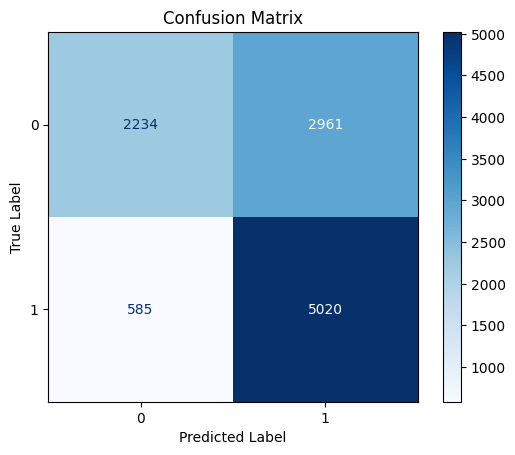

In [205]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.grid(False)
plt.show()


In [206]:

df_2 = df.copy()

In [207]:
garantia = pd.get_dummies(df_2['Garantia'],drop_first=True,prefix='garantia')
incumplio = pd.get_dummies(df_2['Incumplio'],drop_first=True,prefix='incumplio')

df_2 = pd.concat([df_2,garantia,incumplio],axis=1)
df_2.drop(['Historial_Morosidad','Garantia','Incumplio'],axis=1,inplace=True)
df_2.drop(['PD_rango'],axis=1,inplace=True)



In [208]:
df_2.drop(['Periodo','Factura','Cliente','Fecha_Emision','Fecha_Vencimiento','perdida_incumplimiento'],axis=1,inplace=True)

In [209]:
df_2.head()

,Plazo_Pago_Dias,Antiguedad_Cliente_Anios,Saldo_Pendiente,Linea_Credito,dias_vencidos,rango,calculo_clasico,garantia_SI,incumplio_SI
0,30,4.0,12251.38,17556.41,1052,>360 días,3230.208907,True,True
1,45,6.5,40580.18,74804.84,1031,>360 días,16049.105350,False,True
2,45,6.1,6440.01,11375.65,1026,>360 días,2546.967484,False,True
3,60,6.9,20722.41,32190.75,1034,>360 días,8195.531444,False,True
4,90,1.9,9467.73,12403.09,1003,>360 días,2496.269463,True,True


In [210]:
features = X.columns.tolist()

In [211]:
df_model = df_2[features]

In [212]:
df_2['probabilidad_incumplimiento'] = logmodel.predict_proba(df_model)[:, 1]


In [213]:
df_2['prediccion_incumple'] = (df_2['probabilidad_incumplimiento'] >= umbral).astype(int)

In [214]:
df_2['provision_modelo'] = np.minimum (df_2['Saldo_Pendiente'] * df_2['probabilidad_incumplimiento'] * df_2['prediccion_incumple'],df_2['Saldo_Pendiente'] * tope)


In [215]:
df_2.head(5)

,Plazo_Pago_Dias,Antiguedad_Cliente_Anios,Saldo_Pendiente,Linea_Credito,dias_vencidos,rango,calculo_clasico,garantia_SI,incumplio_SI,probabilidad_incumplimiento,prediccion_incumple,provision_modelo
0,30,4.0,12251.38,17556.41,1052,>360 días,3230.208907,True,True,0.733310,1,8984.062425
1,45,6.5,40580.18,74804.84,1031,>360 días,16049.105350,False,True,0.883594,1,32464.144000
2,45,6.1,6440.01,11375.65,1026,>360 días,2546.967484,False,True,0.761624,1,4904.867539
3,60,6.9,20722.41,32190.75,1034,>360 días,8195.531444,False,True,0.782980,1,16225.236912
4,90,1.9,9467.73,12403.09,1003,>360 días,2496.269463,True,True,0.612891,1,5802.688504


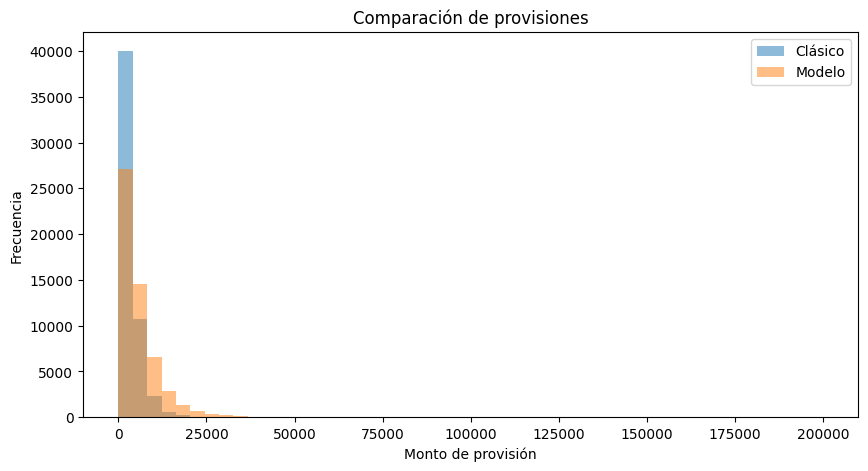

In [216]:
import matplotlib.pyplot as plt

# Calcular bins comunes para ambos histogramas
min_val = min(df_2['calculo_clasico'].min(), df_2['provision_modelo'].min())
max_val = max(df_2['calculo_clasico'].max(), df_2['provision_modelo'].max())
bins = np.linspace(min_val, max_val, 50)

plt.figure(figsize=(10, 5))
plt.hist(df_2['calculo_clasico'], bins=bins, alpha=0.5, label='Clásico')
plt.hist(df_2['provision_modelo'], bins=bins, alpha=0.5, label='Modelo')
plt.legend()
plt.title("Comparación de provisiones")
plt.xlabel("Monto de provisión")
plt.ylabel("Frecuencia")
plt.show()

In [217]:
#Perfil de cliente:

cols_excluir = [
    "probabilidad_incumplimiento",
    "prediccion_incumple",
    "provision_modelo",
    "calculo_clasico",
    "perdida_incumplimiento"
]

# Filtramos el dataframe
df_inputs = df_2.drop(columns=[c for c in cols_excluir if c in df_2.columns])

# Calculamos el perfil solo con inputs
perfil = df_inputs.groupby("incumplio_SI").mean(numeric_only=True).T

perfil.columns = ["Cumplen", "Incumplen"]
perfil["Diferencia_%"] = ((perfil["Incumplen"] - perfil["Cumplen"]) / perfil["Cumplen"] * 100).round(1)

perfil


,Cumplen,Incumplen,Diferencia_%
Plazo_Pago_Dias,37.865184,37.203713,-1.7
Antiguedad_Cliente_Anios,3.532111,3.523667,-0.2
Saldo_Pendiente,12340.157874,12164.246685,-1.4
Linea_Credito,20390.741051,20121.124265,-1.3
dias_vencidos,375.351217,645.353673,71.9
garantia_SI,0.488667,0.419083,-14.2


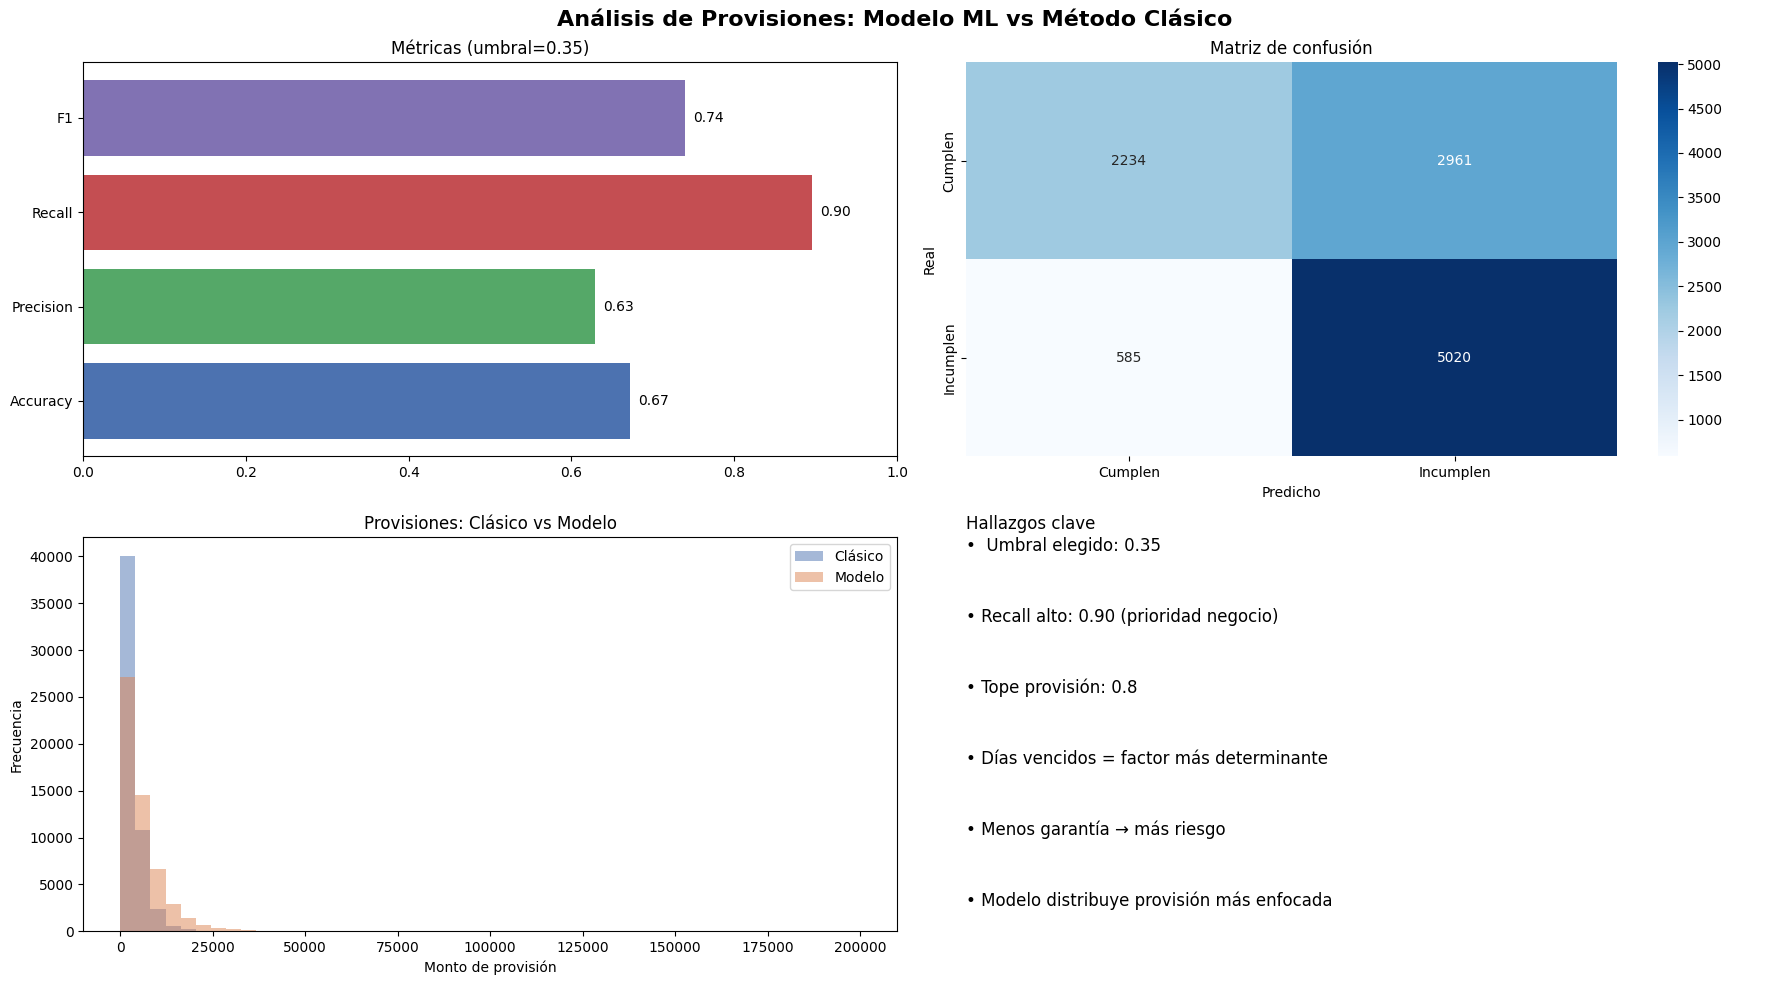

In [228]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Totales
total_saldo    = df_2['Saldo_Pendiente'].sum()
total_clasico  = df_2['calculo_clasico'].sum()
total_modelo   = df_2['provision_modelo'].sum()

# Ratios respecto al total de la cartera
ratio_clasico = (total_clasico / total_saldo * 100).round(2)
ratio_modelo  = (total_modelo  / total_saldo * 100).round(2)

# Diferencia entre ellos
diff_pct = (ratio_modelo - ratio_clasico).round(2)

accuracy = accuracy_
precision = precision_
recall = recall_
f1 = f1_

cm = confusion_matrix(y_test, y_pred)
labels = ["Cumplen","Incumplen"]

min_val = min(df_2['calculo_clasico'].min(), df_2['provision_modelo'].min())
max_val = max(df_2['calculo_clasico'].max(), df_2['provision_modelo'].max())
bins = np.linspace(min_val, max_val, 50)

hallazgos = [
    f" Umbral elegido: {umbral}",
    f"Recall alto: {recall:.2f} (prioridad negocio)",
    f"Tope provisión: {tope}",
    "Días vencidos = factor más determinante",
    "Menos garantía → más riesgo",
    "Modelo distribuye provisión más enfocada",
]

fig = plt.figure(figsize=(18,10))
gs = fig.add_gridspec(2,2)

# (1) Métricas
ax1 = fig.add_subplot(gs[0,0])
ax1.barh(["Accuracy","Precision","Recall","F1"],
         [accuracy, precision, recall, f1],
         color=["#4C72B0","#55A868","#C44E52","#8172B3"])
ax1.set_xlim(0,1); ax1.set_title("Métricas (umbral=0.35)")
for i,v in enumerate([accuracy,precision,recall,f1]):
    ax1.text(v+0.01, i, f"{v:.2f}", va="center")

# (2) Matriz de confusión
ax2 = fig.add_subplot(gs[0,1])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels, ax=ax2)
ax2.set_title("Matriz de confusión"); ax2.set_xlabel("Predicho"); ax2.set_ylabel("Real")

# (3) Histograma comparativo
ax3 = fig.add_subplot(gs[1,0])
ax3.hist(df_2['calculo_clasico'], bins=bins, alpha=0.5, label="Clásico", color="#4C72B0")
ax3.hist(df_2['provision_modelo'], bins=bins, alpha=0.5, label="Modelo", color="#DD8452")
ax3.set_title("Provisiones: Clásico vs Modelo")
ax3.set_xlabel("Monto de provisión"); ax3.set_ylabel("Frecuencia"); ax3.legend()

# (4) Hallazgos clave
ax4 = fig.add_subplot(gs[1,1]); ax4.axis("off")
ax4.set_title("Hallazgos clave", loc="left")
for i, t in enumerate(hallazgos):
    ax4.text(0.0, 1 - i*0.18, f"• {t}", fontsize=12, va="top")

fig.suptitle("Análisis de Provisiones: Modelo ML vs Método Clásico", fontsize=16, fontweight="bold")
plt.tight_layout(); plt.show()

Análisis del modelo y ajustes.

In [219]:
df_2[['calculo_clasico', 'provision_modelo']].describe()

,calculo_clasico,provision_modelo
count,54000.000000,54000.000000
mean,3189.175756,5446.378947
std,2944.829233,6175.164174
min,58.301843,0.000000
25%,1255.708035,0.000000
50%,2385.326301,4057.902183
75%,4170.262561,7695.471368
max,98872.807799,200000.000000


In [220]:
df_2['incumplio_SI'].value_counts(normalize=True)

,proportion
incumplio_SI,
True,0.514704
False,0.485296


In [221]:
totales = df_2.groupby('incumplio_SI')['Saldo_Pendiente'].sum()
ratio = totales / df_2['Saldo_Pendiente'].sum() * 100
print("Participación de saldos (%)")
print(ratio)

Participación de saldos (%)
incumplio_SI
False    48.888333
True     51.111667
Name: Saldo_Pendiente, dtype: float64


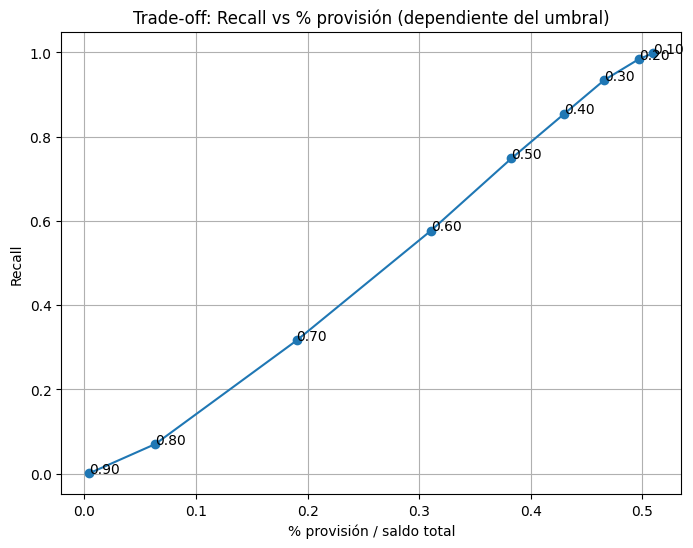

In [222]:
umbrales = np.linspace(0.1, 0.9, 9)
recalls = []
ratios = []

total_saldo = df_2['Saldo_Pendiente'].sum()

for t in umbrales:
    pred = (df_2['probabilidad_incumplimiento'] >= t).astype(int)

    # Recall
    recalls.append(recall_score(df_2['incumplio_SI'], pred))

    # Provisión solo para los que el modelo marca como incumplidores
    provision = df_2['Saldo_Pendiente'] * pred * df_2['probabilidad_incumplimiento']


    ratio = provision.sum() / total_saldo
    ratios.append(ratio)

# Graficar
plt.figure(figsize=(8,6))
plt.plot(ratios, recalls, marker="o")
for i, t in enumerate(umbrales):
    plt.text(ratios[i], recalls[i], f"{t:.2f}")
plt.xlabel("% provisión / saldo total")
plt.ylabel("Recall")
plt.title("Trade-off: Recall vs % provisión (dependiente del umbral)")
plt.grid(True)
plt.show()

In [223]:
# Totales
total_saldo    = df_2['Saldo_Pendiente'].sum()
total_clasico  = df_2['calculo_clasico'].sum()
total_modelo   = df_2['provision_modelo'].sum()

# Ratios respecto al total de la cartera
ratio_clasico = (total_clasico / total_saldo * 100).round(2)
ratio_modelo  = (total_modelo  / total_saldo * 100).round(2)

# Diferencia entre ellos
diff_pct = (ratio_modelo - ratio_clasico).round(2)

print("Saldo total cartera:", round(total_saldo,2))
print("Provisión clásica:", round(total_clasico,2), f"({ratio_clasico}% del saldo)")
print("Provisión modelo :", round(total_modelo,2), f"({ratio_modelo}% del saldo)")
print("El modelo provisiona", diff_pct, "puntos porcentuales más sobre el total")


Saldo total cartera: 661479249.62
Provisión clásica: 172215490.82 (26.03% del saldo)
Provisión modelo : 294104463.15 (44.46% del saldo)
El modelo provisiona 18.43 puntos porcentuales más sobre el total


In [224]:
df_2['diferencia'] = df_2['provision_modelo'] - df_2['calculo_clasico']
df_2.sort_values('diferencia', ascending=False).head(10)

,Plazo_Pago_Dias,Antiguedad_Cliente_Anios,Saldo_Pendiente,Linea_Credito,dias_vencidos,rango,calculo_clasico,garantia_SI,incumplio_SI,probabilidad_incumplimiento,prediccion_incumple,provision_modelo,diferencia
19780,45,1.5,250000.00,496564.92,655,>360 días,98872.807799,False,False,0.999370,1,200000.000000,101127.192201
10169,30,7.1,137215.25,253940.99,866,>360 días,36178.285441,True,True,0.619954,1,85067.151261,48888.865820
8997,30,4.1,107344.22,211481.16,887,>360 días,28302.465153,True,True,0.707251,1,75919.337341,47616.872188
17405,30,6.8,105947.21,192450.86,733,>360 días,41901.192525,False,False,0.960341,1,84757.768000,42856.575475
2699,60,2.8,104334.69,192181.28,1007,>360 días,41263.455004,False,False,0.973327,1,83467.752000,42204.296996
4716,60,0.0,97246.62,149843.51,928,>360 días,38460.185473,False,True,0.947995,1,77797.296000,39337.110527
33721,15,5.5,95871.18,193586.39,395,>360 días,37916.211014,False,True,0.942008,1,76696.944000,38780.732986
19897,30,6.4,95330.72,199134.26,653,>360 días,37702.463824,False,True,0.960960,1,76264.576000,38562.112176
29148,60,6.3,92927.09,145756.33,457,>360 días,36751.849235,False,True,0.847156,1,74341.672000,37589.822765
18335,90,5.1,91072.84,163493.00,640,>360 días,36018.509620,False,False,0.893946,1,72858.272000,36839.762380


In [225]:
df_2.to_csv("dataset_base.csv", index=False)

In [226]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54000 entries, 0 to 53999
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   Plazo_Pago_Dias              54000 non-null  int64   
 1   Antiguedad_Cliente_Anios     54000 non-null  float64 
 2   Saldo_Pendiente              54000 non-null  float64 
 3   Linea_Credito                54000 non-null  float64 
 4   dias_vencidos                54000 non-null  int64   
 5   rango                        54000 non-null  category
 6   calculo_clasico              54000 non-null  float64 
 7   garantia_SI                  54000 non-null  bool    
 8   incumplio_SI                 54000 non-null  bool    
 9   probabilidad_incumplimiento  54000 non-null  float64 
 10  prediccion_incumple          54000 non-null  int64   
 11  provision_modelo             54000 non-null  float64 
 12  diferencia                   54000 non-null  float64 
dtypes

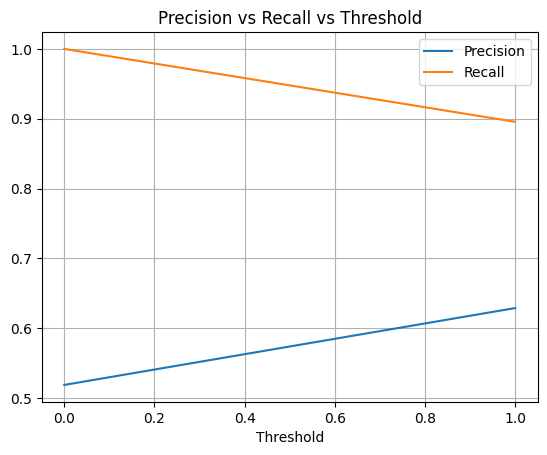

In [227]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.legend()
plt.grid(True)
plt.title("Precision vs Recall vs Threshold")
plt.show()

Prueba con datos sinteticos